In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
from collections import deque
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Input, Dropout, PReLU, Flatten, Lambda, Add
from tensorflow.keras import Model
import tensorflow.keras.backend as K
import datetime
import math
from tqdm import tqdm

---

A very basic implementation of the snake game

---

In [0]:
class Snecc_game():
    
    def __init__(self, grid_size, init_food):
        '''
            grid_size : size of the interior grid (without the borders)

            init_food : number of food items appearing at the start of the game
        '''
        
        assert grid_size > 3
        assert init_food > 0

        self.grid = np.zeros((grid_size + 2, grid_size + 2))
        self.grid_size = grid_size
        self.init_food = init_food
        self.snecc_marker = -2
        self.head_marker = 5
        self.food_marker = -5
        self.empty_marker = 2
        
        
        
    def reset(self):
        '''
            Resets the game. Must be run before each attempt
        '''
        
        self.queue = deque()
        self.empty_squares = []
        self.food_count = 0

        self.grid[1:self.grid_size+1, 1:self.grid_size+1] = self.empty_marker
        self.grid[0, :] = self.snecc_marker
        self.grid[self.grid_size + 1, :] = self.snecc_marker
        self.grid[:, 0] = self.snecc_marker
        self.grid[:, self.grid_size + 1] = self.snecc_marker

        init_snecc1 = np.random.randint(1, self.grid_size + 1)
        init_snecc2 = np.random.randint(1, self.grid_size + 1)
        
        self.queue.append((init_snecc1, init_snecc2))
        self.length = 1
        self.grid[init_snecc1, init_snecc2] = self.head_marker
        
        for i in range(1, self.grid_size + 1):
          for j in range(1, self.grid_size + 1):
            if i!=init_snecc1 or j!=init_snecc2:
              self.empty_squares.append((i, j))
        
        
        self.add_food(self.init_food)
        
        
    def add_food(self, count):
        '''
            count : number of food items to be added
        '''
        
        assert count > 0

        new_count = min(count, len(self.empty_squares))
        for _ in range(new_count):
            
            index = random.choice(range(len(self.empty_squares)))
            food1, food2 = self.empty_squares.pop(index)
            self.grid[food1, food2] = self.food_marker
        
        self.food_count+=new_count
    
    
    def new_head(self, action):
        
        old_head1, old_head2 = self.queue[-1]
        new_head1, new_head2 = old_head1, old_head2
        
        
        if action == 0:
            new_head1 = old_head1 - 1
        elif action == 1:
            new_head1 = old_head1 + 1
        elif action == 2:
            new_head2 = old_head2 - 1
        elif action == 3:
            new_head2 = old_head2 + 1
        
        return new_head1, new_head2

          
    def make_move(self, action):
        
        assert action in range(4)

        reward = 0
        game_over = False
        found_food = False
        new_head1, new_head2 = self.new_head(action)
        
        
        if self.grid[new_head1, new_head2] == self.food_marker:
            
            self.length += 1
            if self.length == self.grid_size * self.grid_size:
                game_over = True
                
            reward = 0.5
            found_food = True
            self.food_count -= 1
            
                
        else:
            
            old_tail = self.queue.popleft()
            if self.grid[new_head1, new_head2] == self.empty_marker or ((new_head1, new_head2) == old_tail and self.length>2):
                reward = 0
                self.grid[old_tail] = self.empty_marker
                self.empty_squares.append(old_tail)
            else:
                reward = -0.5
                game_over = True
        

        if self.length > 1:
            self.grid[self.queue[-1]] = self.snecc_marker

        self.queue.append((new_head1, new_head2))
        self.grid[new_head1, new_head2] = self.head_marker

        if (new_head1, new_head2) in self.empty_squares:
            self.empty_squares.remove((new_head1, new_head2))
        if found_food and self.food_count == 0:
            self.add_food(1)
       
        state = np.reshape(np.copy(self.grid), (self.grid_size + 2, self.grid_size + 2, 1))
        return state, reward, game_over
    
    def get_input(self):
        
        action = -1
        key = input()
        while key not in ('a', 's', 'w', 'd', 'x'):
            key = input()

        key2action = {'w' : 0, 's' : 1, 'a' : 2, 'd' : 3, 'x' : -1}
        action = key2action[key]
        
        return action
    
    def play_human(self):
        
        self.reset()
        self.show_grid()
        
        while True:
            
            action = self.get_input()
            if action == -1:
                break
            _, _, game_over = self.make_move(action)
            self.show_grid()
            if game_over:
                break

        print("============================")
        print("GAME OVER")
        print("SCORE: {}".format(self.length-1))
        print("============================")


    def play_model(self, model, show_grid = False, record = False):

        self.reset()

        state = np.reshape(np.copy(self.grid), (1, self.grid_size + 2, self.grid_size + 2, 1))
        if show_grid:
            self.show_grid()
        if record:
            frames = [state]
        game_over = False
        cnt = 0

        while not game_over:

            action = np.argmax(model.predict(state))
            state, reward, game_over = self.make_move(action)
            state = np.reshape(state, (1, self.grid_size + 2, self.grid_size + 2, 1))
            cnt += 1

            if reward > 0:
                cnt = 0

            if show_grid:
                self.show_grid()

            if record:
                frames.append(state)

            if cnt > self.grid_size * self.grid_size:
                game_over = True
                #print("The model was stuck")

        
        if show_grid:
            print ("SNAKE LENGTH: {}".format(self.length))

        if record:
            return self.length, np.reshape(np.array(frames[:-1]), (len(frames) - 1, self.grid_size + 2, self.grid_size + 2))
        
        return self.length

           
    def show_grid(self):
        
        plt.figure(1, figsize = (5, 5))
        plt.axis('off')
        plt.imshow(self.grid)
        plt.show(block=False)
            

---
Implementation of the SumTree structure. This tree enables efficient weighted sampling. The sampling and updating operations have complexity of O(logn). For more details see [here](https://adventuresinmachinelearning.com/sumtree-introduction-python/) 

---

In [0]:
class SumTree():
    
    def __init__(self, real_size):
        
        self.real_size = real_size
        
        log = math.log(real_size, 2)
        ceil = math.ceil(log)
        power = math.pow(2, ceil)
        
        self.size = int(power)
        self.buffer = np.zeros(2 * self.size - 1)
        self.buffer_idx = 0
        self.values_start = self.size - 1
        
        
    def update(self, idx, value):
        
        assert 0 <= idx < self.real_size
        assert value > 0
        
        idx = self.values_start + idx
        dif = value - self.buffer[idx]
        self.buffer[idx] = value
        
        while True :
            
            idx = (idx - 1) // 2
            self.buffer[idx] += dif
            if idx == 0:
                break
                
    def add(self, value):
        
        assert value > 0
        self.update(self.buffer_idx, value)
        self.buffer_idx +=1
        
        if self.buffer_idx == self.real_size:
            self.buffer_idx = 0
                
    def sample(self):
        
        assert self.buffer[0] > 0
        idx = 0
        guess = np.random.uniform(0, self.buffer[0])
        orig_guess = guess
        
        while idx < self.values_start:
            
            left = 2 * idx + 1
            right = 2 * idx + 2
            
            if guess <= self.buffer[left]:
                idx = left
            else:
                idx = right
                guess -=self.buffer[left]
                
        idx = idx - self.values_start
                
        return idx
                
    def show_buffer(self):
        
        length = 1
        cur = 0
        while cur + length < len(self.buffer) + 1:
            
            print(self.buffer[cur : cur + length])
            cur +=length
            length *= 2


---
The model used for predicting the Q values. The dueling option is described [here](https://adventuresinmachinelearning.com/dueling-q-networks-tensorflow-2/)

---

In [0]:
def create_model(grid_size, hidden_size, dueling = False):
    
    input_= Input(shape = (grid_size, grid_size, 1), name = 'Input')
    x = Conv2D(16, kernel_size = 3, activation = 'relu',
           input_shape = (grid_size, grid_size, 1),
              name = 'Conv1') (input_)
    x = Conv2D(32, kernel_size = 3, activation = 'relu', name = 'Conv2') (x)
    x = Flatten() (x)
    
    adv_in = Dense(hidden_size, activation = 'relu', name = 'Adv_dense1') (x)
    adv_in = Dropout(0.25) (adv_in)
    adv_out = Dense(num_actions, name = 'Adv_dense2') (adv_in)
    
    if dueling:
        
        v_in = Dense(hidden_size, activation = 'relu', name = 'V_dense1') (x)
        v_in = Dropout(0.25) (v_in)
        v_out = Dense(1, name = 'V_dense2') (v_in)
        
        adv_norm = Lambda(lambda x : x - tf.reduce_mean(x)) (adv_out)
        combined = Add() ([v_out, adv_norm])
        return Model([input_], [combined])
    
    return Model([input_], [adv_out])
        
    

---
The parameters for the learning procedure

---

In [0]:
inner_grid_size = 7
grid_size = inner_grid_size + 2
batch_size = 64
epochs = 2000
num_actions = 4
hidden_size = 128
init_food = inner_grid_size - 2

gamma = 0.92
init_epsilon = 0.6
memory_size = 10000
delay_training = memory_size // 20
tau = 0.1

primary_model = create_model(grid_size, hidden_size, True)
target_model = create_model(grid_size, hidden_size, True)

primary_model.compile(optimizer = 'adam',
                     loss = tf.keras.losses.Huber())

for p, t in zip(primary_model.trainable_variables,
                target_model.trainable_variables):
    t.assign(p)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 9, 9, 1)]    0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 7, 7, 16)     160         Input[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 5, 5, 32)     4640        Conv1[0][0]                      
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 800)          0           Conv2[0][0]                      
____________________________________________________________________________________________

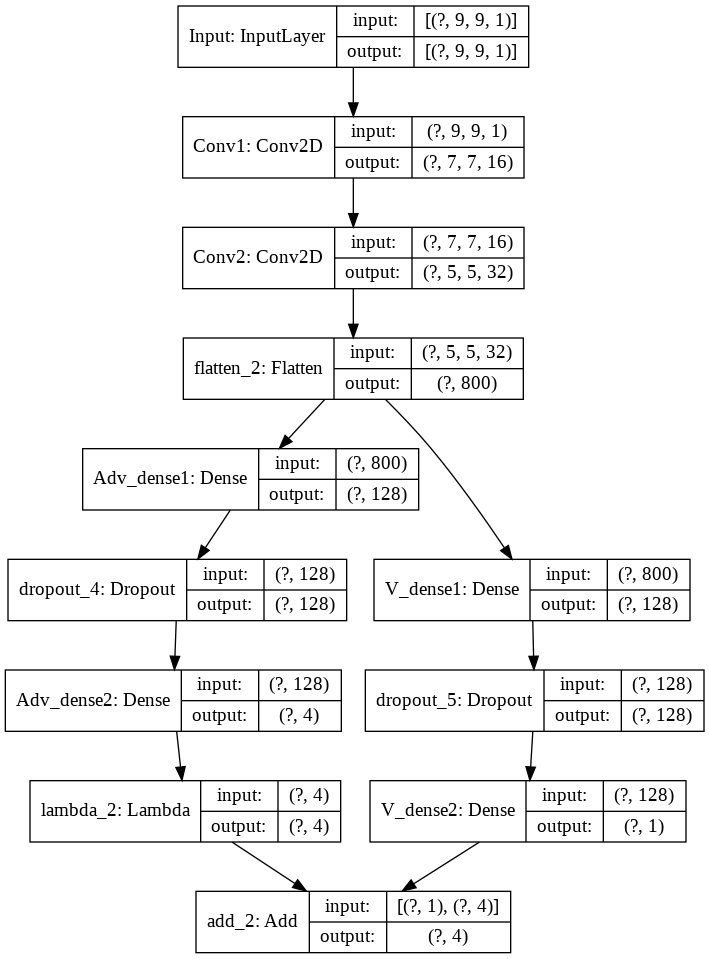

In [0]:
primary_model.summary()
keras.utils.plot_model(primary_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

---
The buffer that contains the saved experiences. During training samples from the memory will be taken randomly. However each sample has a weight that determines its probability of being chosen. For more see [here](https://adventuresinmachinelearning.com/prioritised-experience-replay/)

---

In [0]:
class Memory():
    
    def __init__(self, memory_size, grid_size):
        
        self.memory_size = memory_size
        self.grid_size = grid_size
        self.sum_tree = SumTree(self.memory_size)
        self.buffer = [None] * memory_size
        self.available = 0
        self.buffer_idx = 0
        self.adj_sum = 0.06
        self.adj_pow = 0.6
        
        
    def memorize(self, episode, weight):
        
        weight = self.adjust_weight(weight)
        self.buffer[self.buffer_idx] = episode
        self.sum_tree.add(weight)
        
        if self.available < self.memory_size:
            self.available +=1
   
        self.buffer_idx +=1
        if self.buffer_idx == self.memory_size:
            self.buffer_idx = 0
            
    def update(self, idx, weight):
        
        assert idx < self.available
        self.sum_tree.update(idx, weight)
            
    def adjust_weight(self, weight):
        
        weight = weight + self.adj_sum
        weight = np.power(weight, self.adj_pow)
        return weight
    
    
    def sample(self, sample_size):
        
        sample_size = min(sample_size, self.available)
        episode_idxs = []
        states = []
        actions = []
        rewards = []
        next_states = []
        game_overs = []
        
        for _ in range(sample_size):
            
            idx = self.sum_tree.sample()
            episode_idxs.append(idx)
            state, action, reward, next_state, game_over = self.buffer[idx]
            
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            game_overs.append(game_over)
            
        
        states = np.array(states)
        next_states = np.array(next_states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        game_overs = np.array(game_overs)
        
        return states, actions, rewards, next_states, game_overs, episode_idxs
        

---

Important functions for the learning process

---

In [0]:
def choose_action(state, primary_network, epsilon, num_moves):
    
    rand = np.random.uniform(0, 1)
    if num_moves < delay_training or rand < epsilon:
        action = np.random.randint(num_actions)
    else:
        pred = primary_model.predict(np.reshape(state, (1, grid_size, grid_size, 1)))
        action = np.argmax(pred)
        
    return action

def update_network(primary_model, target_model):
    
    for p, t in zip(primary_model.trainable_variables,
                   target_model.trainable_variables):
        
        t.assign(tau * p + (1 - tau) * t)
        
        
        


def huber_loss(loss):
    return 0.5 * loss ** 2 if abs(loss) < 1.0 else abs(loss) - 0.5

huber_loss_vect = np.vectorize(huber_loss)
    
    
    
def get_targets(states, actions, rewards, next_states,
               game_overs, primary_model, target_model, huber = True):
    
    idxs = np.arange(len(actions))
    
   
    q_s_prim = primary_model.predict(states)
    targets = np.copy(q_s_prim)
    
    
    q_s_next_prim = primary_model.predict(next_states)
    next_actions = np.argmax(q_s_next_prim, axis = 1)
    
    
    q_s_next_targ = target_model.predict(next_states)[idxs, next_actions]
    

    
    targets[idxs, actions] = rewards + gamma * (1 - game_overs) * q_s_next_targ
      
    errors = targets[idxs, actions] - q_s_prim[idxs, actions]
    if huber:
        errors = huber_loss_vect(errors)
    else:
        errors = errors ** 2
    
    return targets, errors   



def train_batch(primary_model, target_model, memory, sample_size):
    
    states, actions, rewards, next_states, game_overs, episode_idxs = memory.sample(sample_size)
    
    targets, _ = get_targets(states, actions, rewards, next_states,
                                 game_overs, primary_model, target_model)
    
    loss = primary_model.train_on_batch(states, targets)
    
    _, errors = get_targets(states, actions, rewards, next_states,
                                 game_overs, primary_model, target_model)
    
    for idx, weight in zip(episode_idxs, errors):
        
        memory.update(idx, weight)
        
    return loss

---

The main training function

---

In [0]:
def train():
    
    train_start = datetime.datetime.now()
    snecc = Snecc_game(inner_grid_size, init_food)
    
    memory = Memory(memory_size, grid_size)
    total_moves = 1
    epsilon = init_epsilon
    
    for epoch in range(1, epochs + 1):
        
        epoch_start = datetime.datetime.now()
        avg_loss = 0.0
        snecc.reset()
        game_over = False
        state = snecc.grid.reshape((grid_size, grid_size, 1))
        moves = 1
        
        while not game_over:
            
            old_state = np.copy(state)
            
            action = choose_action(old_state, primary_model, epsilon, total_moves)
            
            state, reward, game_over = snecc.make_move(action)
            
            episode = [old_state, action, reward, state, game_over]
            
            if total_moves > delay_training:
                
                loss = train_batch(primary_model, target_model, memory, batch_size)
                update_network(primary_model, target_model)
                
                old_state_temp = np.reshape(np.copy(old_state), (1, grid_size, grid_size, 1))
                state_temp = np.reshape(np.copy(state), (1, grid_size, grid_size, 1))
                actions_temp = np.array([action])
                rewards_temp = np.array([reward])
                game_overs_temp = np.array([game_over])
                
                
                _, weight = get_targets(old_state_temp, actions_temp, rewards_temp, state_temp,
                                       game_overs_temp, primary_model, target_model)
                  
                epsilon = max(0.1, init_epsilon - epoch * 0.001)
                
            else:
                
                loss = 0
                weight = np.abs(reward) if reward >= 0 else (1.0 * np.abs(reward)) / 2.0
                
            memory.memorize(episode, weight)
            avg_loss += loss
                
            print("Epoch: {}| Move: {}| Length: {}| Loss : {}".format(epoch, moves, snecc.length, loss))

            moves +=1
            total_moves +=1
        
        
        avg_loss = avg_loss / (moves + 1)
        length = snecc.length
        epoch_time = datetime.datetime.now() - epoch_start
        print("Epoch {}/{}| Time: {}| Length: {}| Moves: {}| Total_moves: {}| Avg_loss : {}".format(epoch, epochs, epoch_time, length, moves -1, total_moves -1, avg_loss))
    
    total_time = datetime.datetime.now() - train_start
    print("Training is over. Total time: {}".format(total_time))
            

In [0]:
train()

In [0]:
primary_model.save('primary_model.h5')
target_model.save('target_model.h5')




---

The following function creates mp4 animation given an array of images. I initially attempted to make a gif file but Matplotlib didn't want to, so I had to convert  mp4 into gif manually.

---

In [0]:
def create_mp4(frames, interval = 200, cmap = 'hot'):

    fig = plt.figure(figsize = (12, 12))
    plt.axis('off')

    imgs = []
    for frame in frames:
      
        img = plt.imshow(frame, animated=True, cmap = cmap)
        imgs.append([img])

    ani = animation.ArtistAnimation(fig, imgs, interval=interval, blit=True,
                                    repeat_delay=1000)
    

    name = 'snake.mp4'
    ani.save(name)#, writer = writer)
    files.download(name)

    plt.show()

In [0]:
best_frames = None

def create_propaganda(cnt = 100):

    assert cnt > 0
    best_length = -1
    global best_frames

    snecc = Snecc_game(inner_grid_size, 1)


    for _ in tqdm(range(cnt)):

      length, frames = snecc.play_model(primary_model, show_grid = False, record = True)
      if length > best_length:
          best_length = length
          best_frames = frames

    print("Best length: {}".format(best_length))
    create_mp4(best_frames)
    return best_frames



In [0]:
test = create_propaganda(1000)


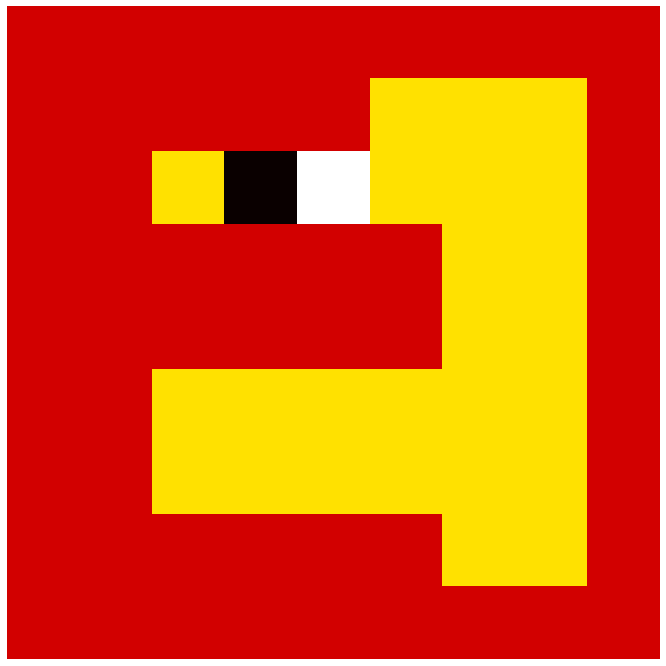

In [145]:
create_mp4(best_frames, cmap = 'hot')